## Tracking individual bands (aka modes) in PWEM.
This is a problem of sorting the eigenvectors that come out of the eigensolution.

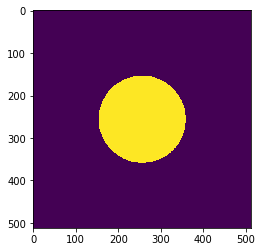

(121, 121)
<class 'numpy.ndarray'>


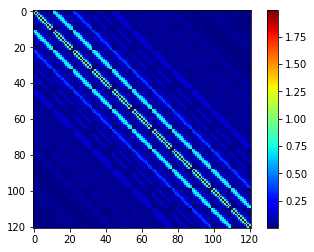

[[ 31.416+0.j   0.   +0.j   0.   +0.j ...   0.   +0.j   0.   +0.j
    0.   +0.j]
 [  0.   +0.j  25.133+0.j   0.   +0.j ...   0.   +0.j   0.   +0.j
    0.   +0.j]
 [  0.   +0.j   0.   +0.j  18.85 +0.j ...   0.   +0.j   0.   +0.j
    0.   +0.j]
 ...
 [  0.   +0.j   0.   +0.j   0.   +0.j ... -18.85 +0.j   0.   +0.j
    0.   +0.j]
 [  0.   +0.j   0.   +0.j   0.   +0.j ...   0.   +0.j -25.133+0.j
    0.   +0.j]
 [  0.   +0.j   0.   +0.j   0.   +0.j ...   0.   +0.j   0.   +0.j
  -31.416+0.j]]
[[ 31.416   0.      0.    ...   0.      0.      0.   ]
 [  0.     31.416   0.    ...   0.      0.      0.   ]
 [  0.      0.     31.416 ...   0.      0.      0.   ]
 ...
 [  0.      0.      0.    ... -31.416   0.      0.   ]
 [  0.      0.      0.    ...   0.    -31.416   0.   ]
 [  0.      0.      0.    ...   0.      0.    -31.416]]


<Figure size 432x288 with 0 Axes>

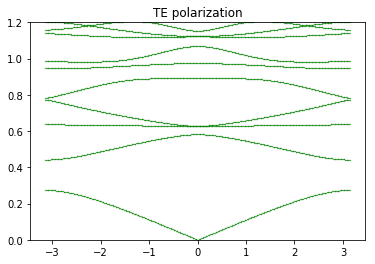

In [82]:
import numpy as np
import sys
sys.path.append("D:\\RCWA\\")

import numpy as np
import matplotlib.pyplot as plt
from convolution_matrices import convmat2D as cm
from PWEM_functions import K_matrix as km
from PWEM_functions import PWEM_eigen_problem as eg
'''
solve PWEM for a simple circular structure in a square unit cell
and generate band structure
compare with CEM EMLab; also Johannopoulos book on Photonics
'''

## lattice and material parameters
a = 1;
radius = 0.2*a;
e_r = 8.9;
c0 = 3e8;
#generate irreducible BZ sample
T1 = 2*np.pi/a;
T2 = 2*np.pi/a;

# determine number of orders to use
P = 5;
Q = 5;
PQ = (2*P+1)*(2*Q+1)
# ============== build high resolution circle ==================
Nx = 512; Ny = 512;
A = np.ones((Nx,Ny));
ci = int(Nx/2); cj= int(Ny/2);
cr = (radius/a)*Nx;
I,J=np.meshgrid(np.arange(A.shape[0]),np.arange(A.shape[1]));

dist = np.sqrt((I-ci)**2 + (J-cj)**2);
A[np.where(dist<cr)] = e_r;

#visualize structure
plt.imshow(A);
plt.show()

## =============== Convolution Matrices ==============
E_r = cm.convmat2D(A, P,Q)
print(E_r.shape)
print(type(E_r))
plt.figure();
plt.imshow(abs(E_r), cmap = 'jet');
plt.colorbar()
plt.show()

## =============== K Matrices =========================
beta_x = beta_y = 0;
plt.figure();

## check K-matrices for normal icnidence
Kx, Ky = km.K_matrix_cubic_2D(0,0, a, a, P, Q);
   

np.set_printoptions(precision = 3)

print(Kx.todense())
print(Ky.todense())

band_cutoff = PQ; #number of bands to plot
## ======================== run band structure calc ==========================##
kx_scan = np.linspace(-np.pi, np.pi, 400)/a;
kx_mat = np.repeat(np.expand_dims(kx_scan, axis = 1), PQ,axis = 1)

TE_eig_store = []
eigen_vectors_store = [];
for beta_x in kx_scan:
    beta_y = beta_x;
    beta_y = 0;
    Kx, Ky = km.K_matrix_cubic_2D(beta_x, beta_y, a, a, P, Q);
    eigenvalues, eigenvectors, A_matrix = eg.PWEM2D_TE(Kx, Ky, E_r); #we solve for E field components... Ez specifically
    #eigenvalues...match with the benchmark...but don't match with
    TE_eig_store.append(np.sqrt(np.real(eigenvalues)));
    eigen_vectors_store.append((eigenvectors))
    #plt.plot(beta_x*np.ones((PQ,)), np.sort(np.sqrt(eigenvalues)), '.')
TE_eig_store = np.array(TE_eig_store);
eigen_vectors_store = np.array(eigen_vectors_store);

    # question: which eigenvalues are relevant for plotting the band structure?


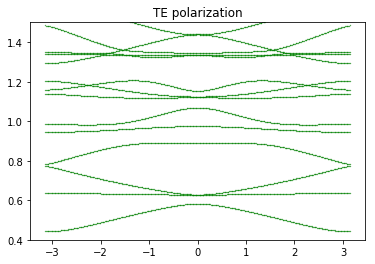

In [84]:
plt.figure()
plt.plot(kx_mat[:,0:band_cutoff], TE_eig_store[:,0:band_cutoff]/(2*np.pi),'.g', markersize = 0.6);
plt.title('TE polarization')
plt.ylim([0.4,1.5])
plt.show();

In [85]:
print(TE_eig_store.shape)

(400, 121)


4
5
6
7
8
9
10
11
12


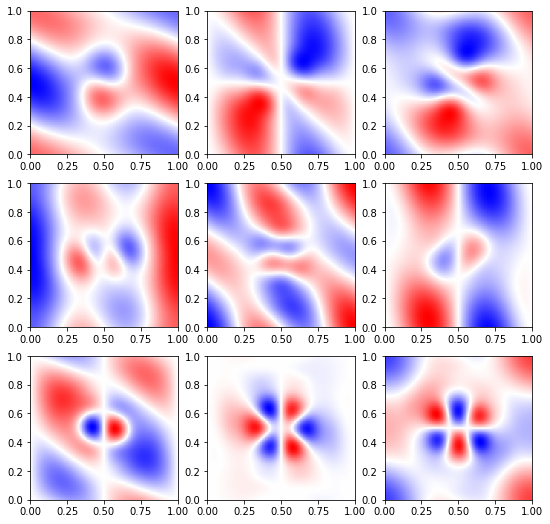

In [122]:
## Reconstructing the mode

# print(eigen_vectors_store.shape)
# print(eigen_vectors_store[:,2,:].shape)
## 1000 sampled points...each one is a 121x121 matrix.
#121 x121 is the discretization in fourier space...so we have to reconstruct the fourier series.
# at each frequency, we got 121 modes, each consisting of 11x11 fourier orders

## test at kx = 0, ky = 0

# beta_x = 0; beta_y = 0;
# Kx, Ky = km.K_matrix_cubic_2D(beta_x, beta_y, a, a, P, Q);
# eigenvalues, eigenvectors, A_matrix = eg.PWEM2D_TE(Kx, Ky, E_r); #we solve for E field components... Ez specifically
# eig1_coeffs = np.reshape(eigenvectors[:,49],(2*P+1, 2*Q+1)); #first index is mode...

#print(np.round(eigenvalues, 3))

k_index = 50;
plt.figure(figsize = (9,9))
c = 1;
for freq_index in range(4,4+9):
    print(freq_index)
    ax = plt.subplot(3,3,c)
    eigenvals = TE_eig_store[k_index,:];
    #get sorted indices
    sorted_inds = np.argsort(eigenvals);
    #print(sorted_inds)
    eigenvals = eigenvals[sorted_inds];
    selected_index = 1;
    eig1_coeffs = eigen_vectors_store[k_index,:,:];
    eig1_coeffs = eig1_coeffs[:, sorted_inds]
    eig1_coeffs = np.reshape(eig1_coeffs[:,freq_index],(2*P+1, 2*Q+1)); #first index is mode...
    x = np.linspace(-a/2, a/2, 200);
    y = np.linspace(-a/2, a/2, 200)
    x = np.linspace(0, a, 200);
    y = np.linspace(0, a, 200)
    X,Y = np.meshgrid(x,y);
    # kx_scan = np.diag(Kx.todense());
    # ky_scan = np.diag(Ky.todense())
    #print(beta_x, beta_y, np.arange(-int(P), int(P)+1))
    Kx_scan = beta_x - 2*np.pi*np.arange(-int(P), int(P)+1)/a;
    Ky_scan = beta_y - 2*np.pi*np.arange(-int(Q), int(Q)+1)/a;

    #print(np.round(Kx_scan, 3))
    reconstruction = 0;

    for i in range(-P, P+1):
        for j in range(-Q, Q+1):
            #we need teh P offset since teh (0,0) happens at the center.
            reconstruction += eig1_coeffs[P+i,Q+j]*np.exp(-1j*(Kx_scan[P+i]*X + Ky_scan[Q+j]*Y))
    #print(reconstruction.shape)
    c = c+1;
    ax.pcolor(X,Y, np.real(reconstruction), cmap = 'bwr');
#plt.axes().set_aspect('equal')
plt.savefig('sample_mode_reconstructions_PWEM_photonic_circle.png', dpi = 300);
plt.show()

In [81]:
def reconstruct_real_space_2D(x, y, Kx_scan, Ky_scan, orders):
    '''
    orders should be an nxm matrix (so reshape the eigenvector of coeffs)
    '''
    X,Y = np.meshgrid(x,y);
    P,Q = orders.shape//2;
    reconstruction = 0;

    for i in range(-P, P+1):
        for j in range(-Q, Q+1):
            #we need teh P offset since teh (0,0) happens at the center.
            reconstruction += orders[P+i,Q+j]*np.exp(-1j*(Kx_scan[P+i]*X + Ky_scan[Q+j]*Y))
    return reconstruction

## Mode tracking != band tracking
The problem is that a given mode will not look the same as we modulate $k_x$ or $k_y$, so we can't simply just cluster modes (nor can we do the parity sorting like we did for 1D systems.

## Alternative: Mode sorting
What if we sort the eigenvalues and the subsequent eigenvector indices?

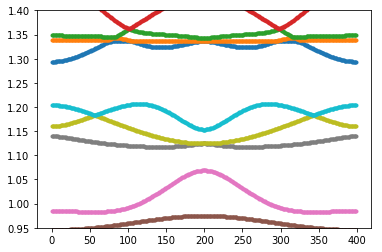

In [113]:
## here we attempt to sort eigenvalues in TE_eig_store into individual bands
# sort every column of TE_eigs_store
TE_sorted = np.sort(TE_eig_store, axis = 1);
for i in range(TE_sorted.shape[1]):
    plt.plot(TE_sorted[:,i]/(2*np.pi), '.');

plt.ylim([0.95,1.4])
plt.show();